<a href="https://colab.research.google.com/github/vladi29/ANA-Classifier/blob/main/binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Universidad Simon Bolivar - 26 de Enero de 2022
# Trabajo final de grado: Clasificador de patrones ANA
# Vladimir Alfaro - 1510023

# Creacion, entrenamiento y prueba de una red para clasificacion binaria

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
import time
import h5py

device = "cuda" if torch.cuda.is_available() else "cpu"

# Cleaning the VRAM memory
#torch.cuda.empty_cache()
#torch.cuda.reset_peak_memory_stats(device=None)
#print("Espacio disponible en GPU (Gb): ", torch.cuda.memory_allocated()*1e-9)

In [2]:
#----------Paths----------

images_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Augmented_dataset/'
original_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_labels.csv'
original_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/original_names.csv'
augmented_labels_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_labels.csv'
augmented_names_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/augmented_names.csv'
original_ds_path = r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Original_dataset.h5'
augmented_ds_path =r'drive/MyDrive/Colab_Notebooks/Tesis/Preprocessing/Augmented_dataset.h5'

original_names = pd.read_csv(original_names_path, header = None)
original_names = original_names.values.tolist()

labels_raw = pd.read_csv(original_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
original_labels = []
for label in labels_raw:
  original_labels.append(label[0])

augmented_names = pd.read_csv(augmented_names_path, header = None)
augmented_names = augmented_names.values.tolist()

labels_raw = pd.read_csv(augmented_labels_path, header = None)
labels_raw = labels_raw.values.tolist()
augmented_labels = []
for label in labels_raw:
  augmented_labels.append(label[0])

Tensor de pesos:  tensor([0.7205, 0.2795])


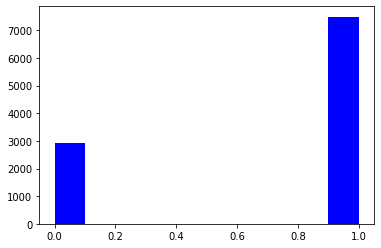

Muestras en el set de entrenamiento:  6237
Muestras en el set de validacion:  2079
Muestras en el set de pruebas:  2079


In [3]:
# Preparando la data para usar Cross Entropy Loss con balanceo de clases
augmented_data = True

if(augmented_data):
  labels = augmented_labels
  names = augmented_names
else:
  labels = original_labels
  names = original_names

binary_labels = []
for label in labels:
  _class = [0, 0]
  if label == 'Negative':
    _class[0], _class[1] = 1, 0
  else: 
    _class[0], _class[1] = 0, 1
  binary_labels.append(_class)

Negatives, Positives= 0, 0

weights, histogram_data = [], []

for labels in binary_labels:  
  if labels[0] == 1:
    Negatives += 1
    histogram_data.append(0)
  if labels[1] == 1:
    Positives += 1
    histogram_data.append(1)

# Creacion de un vector de pesos para balancear las clases
weights.append(Negatives)
weights.append(Positives)
weights = np.array(weights)
weights = 1/weights
weights = weights/np.sum(weights)
weights = torch.tensor(weights, dtype=torch.float)
print("Tensor de pesos: ", weights)
plt.hist(histogram_data, facecolor = 'blue', alpha = 1)
plt.show()

#Division de la data para entrenar, validar y probar la red
x_train, x_val_test, y_train, y_val_test = train_test_split(names, binary_labels, test_size = 0.4, random_state=123)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, random_state=123)

print("Muestras en el set de entrenamiento: ", len(x_train))
print("Muestras en el set de validacion: ", len(x_val))
print("Muestras en el set de pruebas: ", len(x_test))


tensor([0, 1])


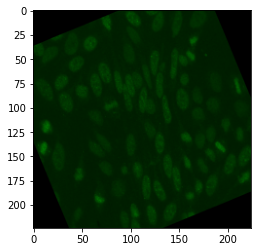

tensor([0, 1])


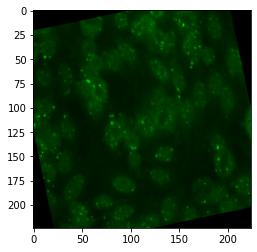

tensor([1, 0])


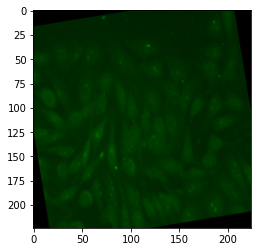

In [4]:
#Clase Dataset Personaliazdo

class CustomImageDataset(Dataset):
    def __init__(self, dataset, names, labels, transform=None):
        self.dataset = dataset
        self.names = names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.names[idx][0].split('.')[0]
        image = self.dataset.get(image_name)[:] 
        image = torch.tensor(image)  
        label = torch.tensor(self.labels[idx])
        label = torch.reshape(label, (2, ))   #label = torch.reshape(label, (1, )) para BCEloss

        if self.transform:
            image = self.transform(image)
        
        return image, label

#Creando Dataloader para los conjuntos de entrenamiento y prueba

if(augmented_data):
  dataset = h5py.File(augmented_ds_path, 'r')
else:
  dataset = h5py.File(original_ds_path, 'r')


Batch_size = 64

train_data = CustomImageDataset(dataset, x_train, y_train) # transform=Custom_transform
train_dataloader = DataLoader(train_data, batch_size=Batch_size, shuffle=False, num_workers=2)   #-------------------------Cambiar el shuffle-----------------------

val_data = CustomImageDataset(dataset, x_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=Batch_size, shuffle=False, num_workers=2)       #-------------------------Cambiar el shuffle----------------------- 

test_data = CustomImageDataset(dataset, x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=Batch_size, shuffle=False, num_workers=2)    #-------------------------Cambiar el shuffle-----------------------

images, labels = next(iter(train_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(val_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

images, labels = next(iter(test_dataloader))
plt.imshow(images[0])
print(labels[0])
plt.show()

In [5]:
# Clase para adaptar modelo pre-entrenados

class MyExtendedNet(nn.Module):
    def __init__(self, pretrained_model):
        super(MyExtendedNet, self).__init__()
        self.pretrained = pretrained_model
        self.new_layer = nn.Sequential(nn.Linear(1000, 1000),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(1000, 500),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(500, 100),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(100, 10),
                                         nn.ReLU(),
                                         nn.Dropout(0.2),
                                         nn.Linear(10, 2), # nn.Linear(10, 1), para BCELoss
                                         #nn.Sigmoid()      # Para BCELoss
                                         )     
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.pretrained(x)
        x = self.new_layer(x)
        return x

In [6]:
def train_model_2(model, optimizer, loss_fn, train_dataloader, val_dataloader, epochs, device):

    model.to(device)
    training_loss, validation_loss = [], []
    aux_loss = 0.1
    aux_acc = 0.9
    average = 'weighted'

    for epoch in range(0, epochs):
        model.train()
        train_loss, train_acc, train_prec, train_recall, train_f1 = [], [], [], [], []
        for batch in iter(train_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            optimizer.zero_grad()
            Y_hat = model(X)
            loss = loss_fn(Y_hat, Y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0
            
            # Metricas
            # GPU
            if (device == torch.device('cuda:0')):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=1)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=1)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=1)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=1)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
            
            train_acc.append(acc)
            train_prec.append(prec) 
            train_recall.append(recall)
            train_f1.append(f1)
        
        model.eval()
        val_loss, val_acc, val_prec, val_recall, val_f1 = [], [], [], [], []
        with torch.no_grad():
            for batch in iter(val_dataloader):
                X, Y = batch
                X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
                Y_hat = model(X)
                loss = loss_fn(Y_hat, Y)
                val_loss.append(loss.item())
                
                Y_hat[Y_hat > 0.5] = 1
                Y_hat[Y_hat < 1] = 0

                # Metricas
                # GPU
                if (device == torch.device('cuda:0')):
                  acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
                  prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
                  recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
                  f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
                # CPU
                else:
                  acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
                  prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
                  recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
                  f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
                
                val_acc.append(acc)
                val_prec.append(prec) 
                val_recall.append(recall)
                val_f1.append(f1)
        
        print(f"Epoca:{epoch + 1}/{epochs} \n")
        print(f"train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f} \n")
        print(f"train acc: {np.mean(train_acc):.5f}, val acc: {np.mean(val_acc):.5f} \n")
        print(f"train prec: {np.mean(train_prec):.5f}, val prec: {np.mean(val_prec):.5f} \n")
        print(f"train recall: {np.mean(train_recall):.5f}, val recall: {np.mean(val_recall):.5f} \n")
        print(f"train f1: {np.mean(train_f1):.5f}, val f1: {np.mean(val_f1):.5f} \n")

        if(np.mean(val_loss) < aux_loss):
          aux_loss = np.mean(val_loss)
          print("Menor perdida en validacion  = ", aux_loss, " en la epoca: ", epoch, "\n")

        if(np.mean(val_acc) > aux_acc):
          torch.save(model.state_dict(), 'drive/MyDrive/Colab_Notebooks/Tesis/Models/Binary_model.pt')
          aux_acc = np.mean(val_acc)
          print("Modelo guardado con Accuracy = ", aux_acc, "\n")

        training_loss.append(np.mean(train_loss))
        validation_loss.append(np.mean(val_loss))
         
    return training_loss, validation_loss

In [10]:
def test_model_2(model, test_loader, device):
    
    model.load_state_dict(torch.load('drive/MyDrive/Colab_Notebooks/Tesis/Models/Binary_model(better).pt', map_location=device))
    print("Modelo cargado.\n")
    
    model.to(device)
    average = 'weighted'
    model.eval()
    test_loss, test_acc, test_prec, test_recall, test_f1 = [], [], [], [], []
    with torch.no_grad():
        for batch in iter(test_dataloader):
            X, Y = batch
            X, Y = X.to(device, torch.float32), Y.to(device, torch.float32)
            Y_hat = model(X)

            Y_hat[Y_hat > 0.5] = 1
            Y_hat[Y_hat < 1] = 0

            print('Salidas comparadas [Y,Y_hat]: ', torch.cat((Y, Y_hat), 1))
            
            # Metricas
            # GPU
            if (device == torch.device('cuda:0')):
              acc = accuracy_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy())
              prec = precision_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
              recall = recall_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0)
              f1 = f1_score(Y.cpu().detach().numpy(), Y_hat.cpu().detach().numpy(), average=average, zero_division=0) 
            # CPU
            else:
              acc = accuracy_score(Y.detach().numpy(), Y_hat.detach().numpy())
              prec = precision_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
              recall = recall_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
              f1 = f1_score(Y.detach().numpy(), Y_hat.detach().numpy(), average=average, zero_division=0)
            
            test_acc.append(acc)
            test_prec.append(prec) 
            test_recall.append(recall)
            test_f1.append(f1)
    
    return(np.mean(test_acc), np.mean(test_prec), np.mean(test_recall), np.mean(test_f1))

In [8]:
!pip install timm
import torchvision.models as models
import timm

# Creacion del modelo

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#model = models.alexnet(pretrained=True)
model = models.densenet201(pretrained=True)
#model = timm.create_model('inception_resnet_v2', pretrained=True)
binary_model = MyExtendedNet(model)

#binary_model = InmunoNet(3, 1)
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss(weight=weights)
epochs = 50
if torch.cuda.is_available():
    binary_model.to(device)
    weights = torch.tensor(weights, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=weights).to(device)

optimizer = torch.optim.Adam(binary_model.parameters(), lr = 0.001)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoca:1/50 

train loss: 0.15373, val loss: 0.13202 

train acc: 0.59428, val acc: 0.67249 

train prec: 0.95397, val prec: 0.92900 

train recall: 0.59444, val recall: 0.67249 

train f1: 0.71097, val f1: 0.76335 

Epoca:2/50 

train loss: 0.11424, val loss: 0.13154 

train acc: 0.71383, val acc: 0.73025 

train prec: 0.96052, val prec: 0.92440 

train recall: 0.71415, val recall: 0.73025 

train f1: 0.81050, val f1: 0.79709 

Epoca:3/50 

train loss: 0.12399, val loss: 0.21390 

train acc: 0.67607, val acc: 0.84126 

train prec: 0.95975, val prec: 0.91952 

train recall: 0.67655, val recall: 0.84126 

train f1: 0.78650, val f1: 0.86482 

Epoca:4/50 

train loss: 0.09907, val loss: 0.10371 

train acc: 0.76597, val acc: 0.76532 

train prec: 0.95746, val prec: 0.93812 

train recall: 0.76756, val recall: 0.76532 

train f1: 0.84709, val f1: 0.82681 

Epoca:5/50 

train loss: 0.08642, val loss: 0.12353 

train acc: 0.80618, val acc: 0.67776 

train prec: 0.95212, val prec: 0.92429 

tr

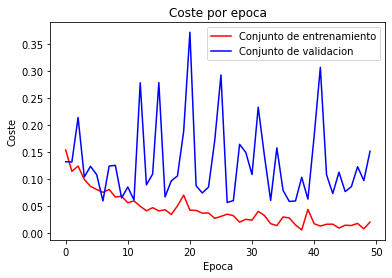

In [9]:
# Entrenamiento y validacion

start_time = time.time()
training_cost, validation_cost = train_model_2(
    binary_model,
    optimizer,
    loss_fn, 
    train_dataloader, 
    val_dataloader,  
    epochs,
    device)
final_time = time.time() - start_time

#print("Estructura del modelo: \n", binary_model, "\n")
print('Tiempo de entrenamiento:', round(final_time/60, 3), "\n")
plt.plot(range(epochs), training_cost, color = "r", label = "Conjunto de entrenamiento")
plt.plot(range(epochs), validation_cost, color = "b", label = "Conjunto de validacion")
plt.title("Coste por epoca")
plt.xlabel("Epoca")
plt.ylabel("Coste")
plt.legend()
plt.show()

In [11]:
# Prueba del modelo

start_time = time.time()
test_acc, test_prec, test_recall, test_F1 = test_model_2(
    binary_model, 
    test_dataloader, 
    device)
final_time = time.time() - start_time
print('Tiempo de test:', round(final_time/60, 3), "\n")
print("Metricas del test:\n", "Exactitud: ", round(test_acc, 2), " Precision: ",
      round(test_prec, 2), " Recall: ", round(test_recall, 2), " F1: ", round(test_F1, 2))

  # Accuracy = TP + TN / (TP + TN + FP + FN)
  # Precision = TP / (TP + FP)
  # Recall = TP / (TP + FN) 
  # F1 = 2 * (Precision * Recall) / (Precision + Recall)

Modelo cargado.

Salidas comparadas [Y,Y_hat]:  tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 1., 0.],
        [0., 1., 0., 1.],
        [0., 1.,